In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.special import kl_div

import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
import subprocess
import random
import time 

from utils import *
from model_utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from platform import python_version
python_version()

'3.8.10'

# Section 1: Helper functions and set-ups 

In [5]:
## Graphing set-up 
import seaborn as sns
x = np.linspace(-4, 4, 100)
tencent_blue = (0,0.3215686274509804,0.8509803921568627)
tencent_orange = (0.9333333333333333, 0.49411764705882355, 0.2784313725490196)

# Calculate y-values for the standard normal density curve
y_standard_normal = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

# Section 3: Simultation 

In [35]:
J = 500
K = 3 
Q = 1000
uplift_factor = 1.0
L = 1
d = 2

np.random.seed(1)

item_embeddings = np.random.uniform(size=(J, d))
item_promotion = np.random.choice([1, 0], size=J)


In [36]:
# user_embeddings = np.random.uniform(size=(Q, d))
# query_matrix = []
# for each_query in range(Q):
#     selected_indices = np.random.choice(np.arange(J), size = K, replace= False)
#     query_matrix += [selected_indices]
# query_matrix = np.array(query_matrix)
# true_estimate, true_stderr = get_ground_truth(uplift_factor, item_embeddings, 
#                                               item_promotion, user_embeddings, query_matrix)
# (promotions, embeddings, W_matrix, outcome_potential, 
#  exposure_matrix) = DGP_new_heterogeneous_embeddings(uplift_factor, item_embeddings, 
#                                                      item_promotion, user_embeddings, 
#                                                      query_matrix, treated_probability=0.5)
# observed_outcome = np.sum(outcome_potential * exposure_matrix, axis = 1 )
# observed_queries_treatment = np.sum(exposure_matrix * W_matrix, axis = 1 )
# T = observed_outcome[observed_queries_treatment == 1]
# C = observed_outcome[observed_queries_treatment == 0] 
# dim_point, dim_var = dim_est(T, C, 0.5, Q)
# print(f"{true_estimate} ({true_stderr}), DIM {dim_point}({dim_var})")

0.021900941890032555 (0.011642558377016464), DIM 0.07179714834550321(1.6628343535947328)


In [17]:
B = 1
epochs = 1000
M = 100 ## Number of iterations for Hessian matrix estimation 
n_folds = 3

for b in range(B):
    user_embeddings = np.random.uniform(size=(Q, d))
    query_matrix = []
    for each_query in range(Q):
        selected_indices = np.random.choice(np.arange(J), size = K, replace= False)
        query_matrix += [selected_indices]
    query_matrix = np.array(query_matrix)
    true_estimate, true_stderr = get_ground_truth(uplift_factor, item_embeddings, 
                                                  item_promotion, user_embeddings, query_matrix)
    
    (promotions, embeddings, W_matrix, outcome_potential, 
     exposure_matrix) = DGP_new_heterogeneous_embeddings(uplift_factor, item_embeddings, 
                                                         item_promotion, user_embeddings, 
                                                         query_matrix, treated_probability=0.5)
    observed_outcome = np.sum(outcome_potential * exposure_matrix, axis = 1 )
    observed_queries_treatment = np.sum(exposure_matrix * W_matrix, axis = 1 )
    T = observed_outcome[observed_queries_treatment == 1]
    C = observed_outcome[observed_queries_treatment == 0] 
        
    
    ## Cross-fitting indices 
    all_inds = generate_indices(Q, n_folds)

    ## Iterate over each fold for cross-validation. 
    hfuncs_each_fold,  debias_terms_each_fold = {}, {}
    loss_each_fold = {}
    for f in range(n_folds):
        f_start, f_end = all_inds[f]
        f_size = f_end - f_start
        
        ## Cross-fitting
        promotions_train, promotions_test =  train_test_split(promotions, all_inds, f) 
        embeddings_train, embeddings_test =  train_test_split(embeddings, all_inds, f) 
        W_matrix_train, W_matrix_test = train_test_split(W_matrix, all_inds, f)  
        exposure_matrix_train, exposure_matrix_test =train_test_split(exposure_matrix, all_inds, f) 
        observed_outcome_train, observed_outcome_test = train_test_split(observed_outcome, all_inds, f)
        
        inputs_3d_train = np.concatenate([embeddings_train, promotions_train[:, :, np.newaxis], 
                                          W_matrix_train[:, :, np.newaxis], exposure_matrix_train[:, :, np.newaxis]], axis = -1)
        inputs_3d_test = np.concatenate([embeddings_test, promotions_test[:, :, np.newaxis], W_matrix_test[:, :, np.newaxis], 
                                         exposure_matrix_test[:, :, np.newaxis]], axis = -1)
        output_3d_train = np.concatenate([exposure_matrix_train.astype(dtype=float), observed_outcome_train[:, np.newaxis]], axis = 1)

        myModelMultiple = MyModel_embeddings(K, d, 1)
        myModelMultiple.compile(loss=custom_loss, optimizer=tf.keras.optimizers.legacy.Adam())
        history_f = myModelMultiple.fit(inputs_3d_train, output_3d_train, epochs=epochs, verbose=True)
        
        ## Store the training history 
        
        loss_each_fold[f] = history_f
        predict_p_test, _, _, predict_outcome_test = np.split(myModelMultiple.predict(inputs_3d_test), [K, 2*K, 2*K+1], axis=1)

        input_3d_test_treat = np.concatenate([embeddings_test, promotions_test[:, :, np.newaxis], np.ones_like(W_matrix_test)[:, :, np.newaxis], 
                                              exposure_matrix_test[:, :, np.newaxis]], axis = -1)
        input_3d_test_control = np.concatenate([embeddings_test, promotions_test[:, :, np.newaxis], np.zeros_like(W_matrix_test)[:, :, np.newaxis], 
                                                exposure_matrix_test[:, :, np.newaxis]], axis = -1)
        
        predict_p_treat, _, _, predict_outcome_treat = np.split(myModelMultiple.predict(input_3d_test_treat), [K, 2*K, 2*K+1], axis=1)
        predict_p_control, _, _, predict_outcome_control = np.split(myModelMultiple.predict(input_3d_test_control), [K, 2*K, 2*K+1], axis=1)
        

        ## 1. COMPUTE THE GRADIENT OF LOSSS  
        gradient_vector_l = compute_loss_gradient(predict_p_test, exposure_matrix_test, W_matrix_test, 
                                                  predict_outcome_test, observed_outcome_test)




        ## 2. COMPUTE  THE GRADIENT OF H FUNCTION
        gradient_vector_H = compute_value_gradient(predict_p_treat, predict_outcome_treat, predict_p_control, predict_outcome_control)

        
        # 3. FIND THE EXPECTATION OF HESSIAN MATRIX 
        Hessian_all = np.zeros((f_size, (L+2) * K - 1,  (L+2) * K - 1))
        for m in range(M):
            treat_dict_m = permute_treatment_dict(J, L)
            W_matrix_m = []
            for each_query in query_matrix[f_start:f_end]:
                W_matrix_m.append([treat_dict_m[ind] for ind in each_query])
            W_matrix_m = np.array(W_matrix_m)
            inputs_m = np.concatenate([embeddings_test, promotions_test[:, :, np.newaxis], W_matrix_m[:, :, np.newaxis], exposure_matrix_test[:, :, np.newaxis]], axis = -1)
            predict_p_m, _, _, _ = np.split(myModelMultiple.predict(inputs_m), [K, 2*K, 2*K+1], axis=1)
            Hessian = compute_hessian_instance(W_matrix_m, predict_p_m)
            Hessian_all = Hessian_all + Hessian
        Hessian_final = Hessian_all / M
        
        count_finite = 0
        debias_term_f = np.zeros(len(Hessian_final))
        for i in range(f_size):
            if is_invertible(Hessian_final[i]):
                try:
                    debias_term_f[i] = gradient_vector_H[i]@np.linalg.inv(Hessian_final[i])@gradient_vector_l[i]
                    count_finite += 1 
                except: 
                    print("Fail for inversion")


        ## END OF FOR LOOP FOR EACH ITERATION OVER CROSS FITTING
        hfuncs_each_fold[f] = np.sum(predict_p_treat * predict_outcome_treat, axis=1) - np.sum(predict_p_control * predict_outcome_control, axis=1)
        debias_terms_each_fold[f] = debias_term_f
        
    (debias_point, debias_var, undebias_point, undebias_var) = crossfitted_estimate_var(hfuncs_each_fold, debias_terms_each_fold)
    dim_point, dim_var = dim_est(T, C, 0.5, Q)

    path = compose_filename(f"results/new_heterogeneous_synthetic_ab", "csv")
    result_df = pd.DataFrame({"debias_point": [debias_point], "debias_var":[debias_var], "dim": [dim_point], 
                              "dim_var":[dim_var], "undebias_point": [undebias_point], "undebias_var": [undebias_var], 
                              "J" : [J], "Q": [Q],  "K":[K],  "M": [M], "epochs" :[epochs], "n_folds": [n_folds], "uplift_factor": [uplift_factor],
                              "truth": [true_estimate], "truth_stderr": [true_stderr] })
    result_df.to_csv(path)
    print("finish simulation.")


Epoch 1/1000
21/21 [==============================] - 1s 2ms/step - loss: 1.9047
Epoch 2/1000
21/21 [==============================] - 0s 1ms/step - loss: 1.4962
Epoch 3/1000
21/21 [==============================] - 0s 1ms/step - loss: 1.2316
Epoch 4/1000
21/21 [==============================] - 0s 2ms/step - loss: 1.0904
Epoch 5/1000
21/21 [==============================] - 0s 1ms/step - loss: 1.0272
Epoch 6/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.9832
Epoch 7/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.9464
Epoch 8/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.9176
Epoch 9/1000
21/21 [==============================] - 0s 2ms/step - loss: 0.8964
Epoch 10/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.8795
Epoch 11/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.8670
Epoch 12/1000
21/21 [==============================] - 0s 1ms/step - loss: 0.8565
Epoch 13/1000
21/21 [====

In [18]:
debias_point, debias_var, undebias_point, undebias_var, dim_point, dim_var, true_estimate, true_stderr

(0.050213490909840224,
 0.3296403426241404,
 0.0260448,
 0.014308364,
 0.3196524736793301,
 1.5152655902446381,
 0.044398276115953816,
 0.012893404959485537)

In [16]:
debias_point, debias_var, undebias_point, undebias_var, dim_point, dim_var, true_estimate, true_stderr

(0.033748239343086225,
 0.2374444641053639,
 0.028815567,
 0.019082827,
 0.41104481542350346,
 1.440685917497232,
 0.037052579515806205,
 0.012802869834064999)

In [14]:
debias_point, debias_var, undebias_point, undebias_var, dim_point, dim_var, true_estimate, true_stderr

(0.025168071552692056,
 1.3901309176653953,
 0.017671471,
 0.02245999,
 0.42552371872353717,
 5.442232397882217,
 0.037052579515806205,
 0.012802869834064999)

## Plots the training loss 

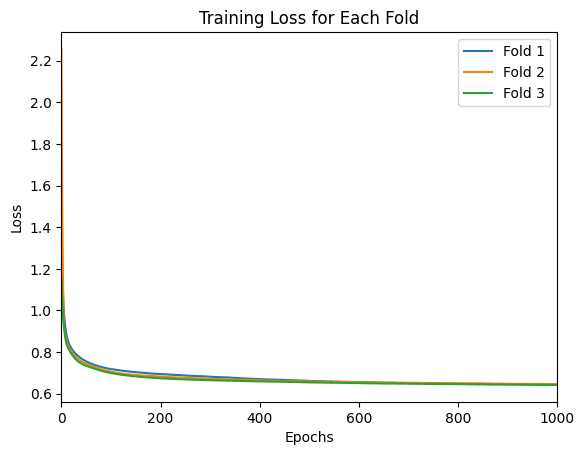

In [26]:
import matplotlib.pyplot as plt
  # assuming history_each_fold is your dictionary

# create a new figure
plt.figure()

# plot the training loss for each fold
for f in range(n_folds):
    plt.plot(loss_each_fold[f].history['loss'], label=f'Fold {f+1}')

# add title and labels
plt.xlim(0,1000)
plt.title('Training Loss for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# add a legend
plt.legend()
plt.savefig("training_loss_simulation.png")

# show the

In [28]:
## Find the goodness of fit for outcome model 
rss = np.sum((outcome_potential_test - predict_outcome_treat) ** 2 )
tss = np.sum(outcome_potential_test ** 2 )
1 - rss / tss

NameError: name 'outcome_potential_test' is not defined

## NDCG loss 

In [31]:
probs_mat = predict_p_test
expos_mat = exposure_matrix_test
import tensorflow_ranking as tfr
def aggregate_probability_exposure_examination(probs_matrix, exposure_matrix): 
    aggregate_probs = np.mean(probs_matrix, axis = 0)
    exposure_probs = np.mean(exposure_matrix, axis = 0)
    ## Euclidean distance 
    euc_dist = np.linalg.norm(aggregate_probs - exposure_probs)
    ## NDCG LOSS 
    y_true = tf.ragged.constant(exposure_matrix)
    y_pred = tf.ragged.constant(probs_matrix)
    loss_NDCG = tfr.keras.losses.ApproxNDCGLoss(ragged=True)
    NDCG_loss_result = loss_NDCG(y_true, y_pred).numpy()
    return euc_dist, aggregate_probs, exposure_probs, NDCG_loss_result

def bootstrap_evaluation(probs_mat, expos_mat, B = 100):
    nrows = probs_mat.shape[0]
    kl_div_list, NDCG_list = [], []
    for b in range(B):
        indices = np.random.choice(nrows, size=nrows, replace=True)
        probs_mat_b = probs_mat[indices,:]
        expos_mat_b = expos_mat[indices,:]

        _, agg_probs_b, agg_expos_b, NDCG_b = aggregate_probability_exposure_examination(probs_mat_b, expos_mat_b)
        kl_divergence_b = kl_div(agg_probs_b,agg_expos_b).sum()

        kl_div_list += [kl_divergence_b]
        NDCG_list += [NDCG_b]

    return kl_div_list, NDCG_list 

ModuleNotFoundError: No module named 'tensorflow_ranking'

In [32]:
kl_, ndcg_ = bootstrap_evaluation(probs_mat.astype(np.float32), expos_mat.astype(np.float32), B = 100)
final_kl =[]
for elm in kl_:
    if np.isfinite(elm):
        final_kl += [elm]
        
final_ndcg =[]
for elm in ndcg_:
    if np.isfinite(elm):
        final_ndcg += [elm]
        

NameError: name 'bootstrap_evaluation' is not defined

In [33]:
res_boot_ndcg_uniform = bootstrap_evaluation(1/K+ 0 * probs_mat.astype(np.float32), expos_mat.astype(np.float32), B = 1 )
# final_kl_uniform =[]
# for elm in res_boot_ndcg_uniform[0]:
#     if np.isfinite(elm):
#         final_kl_uniform += [elm]
        
# final_ndcg_uniform =[]
# for elm in res_boot_ndcg_uniform[1]:
#     if np.isfinite(elm):
#         final_ndcg_uniform += [elm]
        

NameError: name 'bootstrap_evaluation' is not defined

In [34]:
import matplotlib.ticker as ticker

# Your existing code
sns.kdeplot(final_ndcg, color=tencent_blue, label="Empirical Distribution Trained Model")
plt.axvline(x=res_boot_ndcg_uniform[1][0], color="red", label="Random Guess")
plt.axvline(x=np.mean(final_ndcg), color=tencent_orange, label="Trained Model")
plt.legend()

# New code to format x-axis labels
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

plt.savefig("NDCG_simulation.png")

NameError: name 'final_ndcg' is not defined

## Likelihood Ratio Test

In [35]:
import numpy as np
from scipy.stats import chi2

# assuming you have the true labels and predicted probabilities
y_true = expos_mat
y_pred = probs_mat  # predicted probabilities

# calculate log-likelihood for null model
LL_null = np.sum(y_true * np.log(1/K) + (1 - y_true) * np.log(1- 1/K))

# calculate log-likelihood for choice model
LL_model = np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# calculate test statistic
LR = -2 * (  LL_null -LL_model)

# calculate p-value
p_value = chi2.sf(LR, df=K)

In [36]:
LR

399.76062215637467

In [37]:
p_value

2.494630709891525e-86